In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.3 MB/s eta 0:00:00


In [ ]:
#======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#======================================================
import tensorflow as tf
#======================================================
import keras
from keras import layers
#======================================================
from IPython import display
from jiwer import wer
#======================================================

# Downloading dataset

In [ ]:
# Dataset downloading
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

# Reading metadata file and parse it (5 examples)
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(5)

2748572632/2748572632 [==============================] - 27s 0us/step


,file_name,normalized_transcription
0,LJ019-0100,"but the session was far advanced, and the matt..."
1,LJ014-0338,"These bankers, wishing for more specific infor..."
2,LJ050-0130,"Finally, these agreements with Federal and loc..."
3,LJ003-0212,But they nevertheless frequently managed to se...
4,LJ038-0191,five. The money from work will possibly be com...


# Splitting dataset into train and test sets

In [ ]:
# Splitting dataset into train and test sets
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

# Printing train and test sets size info
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the test set: {len(df_val)}")

Size of the training set: 11790
Size of the test set: 1310


# Creating vocabulary

In [ ]:
# Creating vocabulary

# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup( vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True )

# Viewing vocabulary
print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(\nsize ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](
size =31)


# Converting sounds into numeric sequences

In [ ]:
# Converting sounds into numeric sequences

# Parameters for audio signal spectrogram using Fur'ee retrieval

# An integer scalar Tensor. The window length in samples.
frame_length = 256

# An integer scalar Tensor. The number of samples to step.
frame_step = 160

# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

In [ ]:
# Creating func that will preprocess the audio file and its transcription
def encode_single_sample(wav_file, label):
    ###########################################
    ## Process the Audio
    ##########################################

    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)

    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(audio,
                                 frame_length=frame_length,
                                 frame_step=frame_step,
                                 fft_length=fft_length)

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ## Process the label
    ##########################################

    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [ ]:
# Audio files preprocessing and packing
batch_size = 32

# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]),
                                                    list(df_train["normalized_transcription"])))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .padded_batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE))

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((list(df_val["file_name"]),
                                                         list(df_val["normalized_transcription"])))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                      .padded_batch(batch_size)
                      .prefetch(buffer_size=tf.data.AUTOTUNE) )

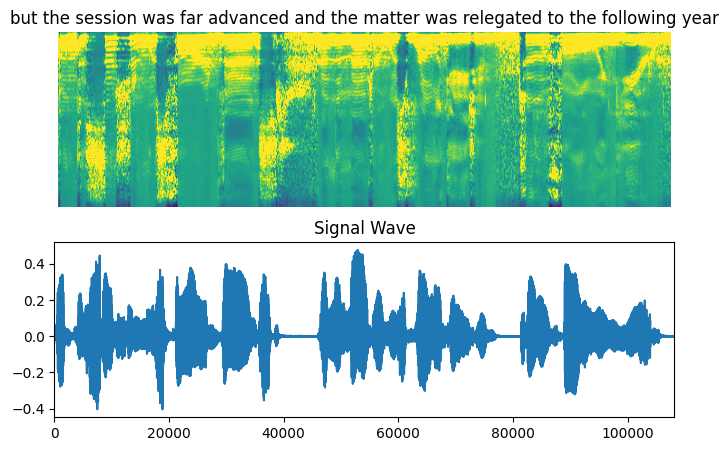

In [ ]:
# Viewing 5 audio file examples, their spectograms and wave forms
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

# Loss calculation function

In [ ]:
# Creating function for loss between real values and predicted values calculation
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# СNN-bi-LSTM neural network model creation

In [ ]:
# СNN-bi-LSTM neural network model creation
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")

    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(filters=32,
                      kernel_size=[11, 41],
                      strides=[2, 2],
                      padding="same",
                      use_bias=False,
                      name="conv_1",)(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(filters=32,
                      kernel_size=[11, 21],
                      strides=[1, 2],
                      padding="same",
                      use_bias=False,
                      name="conv_2", )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units,
                               activation="tanh",
                               recurrent_activation="sigmoid",
                               use_bias=True,
                               return_sequences=True,
                               reset_after=True,
                               name=f"gru_{i}",)

        x = layers.Bidirectional(recurrent,
                                 name=f"bidirectional_{i}",
                                 merge_mode="concat")(x)

        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [ ]:
# Build model
model = build_model(input_dim=fft_length // 2 + 1,
                    output_dim=char_to_num.vocabulary_size(),
                    rnn_units=512,)

# Get model information
model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizat  (None, None, 97, 32)      128       
 ion)                                                            
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

# Function for analyzing training|validation results

In [ ]:
# An utility function to decode the predicted output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)

    return output_text

In [ ]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []

        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)

            for label in y:
                label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)

        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)

        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

# NN training and validation

In [ ]:
# NN training and validation
num_epochs = 5

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)

# Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=num_epochs,
                    callbacks=[validation_callback],)

Epoch 1/5
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target : and thus bring the history of prison discipline down to our own times
Prediction: 
----------------------------------------------------------------------------------------------------
Target : a weight of shot was bought and stowed in carpet bags ready to replace exactly the abstracted gold
Prediction: 
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 2121s 6s/step - loss: 303.9792 - val_loss: 339.5460
Epoch 2/5
1/1 [==============================] - 1s 615ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8988
----------------

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch

    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

for i in np.random.randint(0, len(predictions), 5):
    print(f"Target : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 1s 627ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6181
----------------------------------------------------------------------------------------------------
Target : the man needing all his care for his own life threw the child from him
Prediction: tha man neding al his care for his o life thr ough the ciled from him
----------------------------------------------------------------------------------------------------
Target : and paying great attention to the press work or actual process of printing
Prediction: and pang gratetention to the presor or actual procise of printing
----------------------------------------------------------------------------------------------------
Target : but apparently was not able to spend as much time with them as he would have liked because of the age gaps of five and seven years
Prediction: but aperanly was noabltis end dis much time